In [1]:
from ultimatetictactoe import ultimatetictactoe
from utils.board import BoardRotation, BoardReflection
from rl.independent_algo.agent import RandomAgent, NeuralAgent, ManualAgent, Policy 
from rl.independent_algo.reinforce import *
# from algo.base_algo.base_algo import state_to_tensor

import torch
from torch import nn
import torch.optim as optim

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import random

In [2]:
env = ultimatetictactoe.env(render_mode="rgb_array")
env.reset(42)

envh = ultimatetictactoe.env(render_mode="human")
envh.reset()
# envh.render()

In [3]:
eps = 0.3
a1 = NeuralAgent("player_1", epsilon=eps, learning_power=6, exploration_power=2) # max
a2 = NeuralAgent("player_2", epsilon=eps, learning_power=10.5, exploration_power=1)
am = ManualAgent("player_1")
ar = RandomAgent("player_2")
# a1.policy_net.load_state_dict(torch.load("rl/independent_algo/weights/player_1_res.pt"))
# a2.policy_net.load_state_dict(torch.load("rl/independent_algo/weights/player_2_res.pt"))

# REINFORCE

In [4]:
a1.policy_net.train()
a2.policy_net.train()

Policy(
  (first_conv_net): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): LazyConv2d(0, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (second_conv_net): Sequential(
    (0): LazyConv2d(0, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): LazyConv2d(0, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (5): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
  )
  (final_linear): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): LazyLinear(in_feature

In [5]:
# training
# 10_000 1h 15m
reinforce(env, a1, a2, 1000, enable_swap=True, enable_transform=True, px=0.1, pt=0.5, checkpoint_rate=50)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [07:08<00:00,  2.34it/s]


In [6]:
# torch.save(a1.policy_net.state_dict(), "rl/independent_algo/weights/player_1_res.pt")
# torch.save(a2.policy_net.state_dict(), "rl/independent_algo/weights/player_2_res.pt")

# Stats

In [7]:
# def compute_trajectory_against_random(env, agent1, agent2, collect_log_prob=False, random_player="player_1"):
#     """
#     Collects a trajectory for two agents using env.last() and env.agent_iter().
#     """
#     env.reset()

#     trajectory = {
#         "player_1": {"observations": [], "actions": [], "rewards": []},
#         "player_2": {"observations": [], "actions": [], "rewards": []},
#     }
#     turn = 0
#     for agent in env.agent_iter():
#         obs, reward, termination, truncation, info = env.last()  # get last step info

#         if termination or truncation:
#             action = None  # agent is done, no action to take
#         else:
#             # choose action according to agent
#             if agent == "player_1":
#                 action = agent1.pick_action(obs)['action']
#             else:
#                 action = agent2.pick_action(obs)['action']
#         if isinstance(action, torch.Tensor):
#             if action.device == torch.device("cuda"):
#                 action = action.to(torch.device("cpu"))
#             action = action.item()
#         elif isinstance(action, np.ndarray):
#             action = action.item()


#         # Record observation, action, reward
#         if not (termination or truncation):
#             trajectory[agent]["observations"].append(obs['observation'])
#             trajectory[agent]["actions"].append(action)
#         if turn >= 2:
#             trajectory[agent]["rewards"].append(reward)

#         env.step(action)  # take the action (None if done)
#         turn += 1

#     return trajectory

In [8]:
a1.mode = 'sample'
a2.mode = 'sample'

In [9]:
# a1.policy_net.eval()
# a2.policy_net.eval()
rp = compute_games(env, a1, a2, 100, True)
print('0')
rp1 = compute_games(env, a1, ar, 100, True)
print('1')
rp2 = compute_games(env, a2, ar, 100, True)

0
1


In [10]:
print(rp['results'], rp['rewards'].mean())
print(rp1['results'], rp1['rewards'].mean())
print(rp2['results'], rp2['rewards'].mean())

[61. 22. 17.] 0.381
[58. 32. 10.] 0.256
[31. 44. 25.] -0.132


In [11]:
print(rp['results'], rp['rewards'].mean())
print(rp1['results'], rp1['rewards'].mean())
print(rp2['results'], rp2['rewards'].mean())

[61. 22. 17.] 0.381
[58. 32. 10.] 0.256
[31. 44. 25.] -0.132


In [12]:
import matplotlib.pyplot as plt

def plot_bar(r):
    count = r['rewards_count']
    y1 = [0]*11
    y2 = [0]*11
    y0 = [0]*11
    y0[0]= count[0.0]

    values = [1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    for i in range(len(values)):
        v = values[i]
        for k in count.keys():
            if abs(v-k)<0.0001:
                y1[i+1] = count[k]
            if abs(-v-k)<0.0001:
                y2[i+1] = count[k]
    x = list(range(11))
    plt.bar(x, y0, color='gray', label='Zero')
    plt.bar(x, y1, bottom=y0, color='r', label='Positive')
    plt.bar(x, y2, bottom=[a+b for a,b in zip(y0, y1)], color='b', label='Negative')
    plt.show()
    return y1, y2

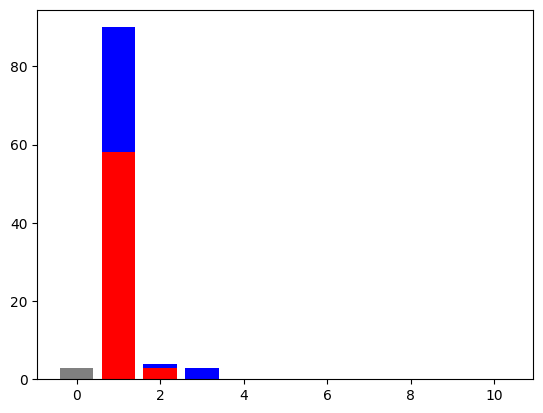

([0, 58.0, 3.0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 32.0, 1.0, 3.0, 0, 0, 0, 0, 0, 0, 0])

In [13]:
plot_bar(rp1)

In [16]:
confidence = 0.95
data = rp2['rewards']
mean = data.mean()
sem = stats.sem(data)
ci = stats.t.interval(confidence, df=len(data)-1, loc=mean, scale=sem)
mean, sem, ci

(np.float64(0.07900000000000001),
 np.float64(0.08747057225204949),
 (np.float64(-0.09456059222068158), np.float64(0.2525605922206816)))

In [17]:
confidence = 0.95
data = rp['game_turns']
mean = data.mean()
sem = stats.sem(data)
ci = stats.t.interval(confidence, df=len(data)-1, loc=mean, scale=sem)
mean, ci

(np.float64(61.62),
 (np.float64(60.30086762254472), np.float64(62.93913237745527)))

In [ ]:
# n = 10000
# envh.metadata['render_fps'] = 2
# macro_result = np.zeros(3)
# result_by_reward = {}
# rew1 = 0
# rew2 = 0
# for _ in range(n):
#     r = compute_trajectory_against_random(env, ar, a2)
#     reward_1 = r['player_1']['rewards'][-1]
#     rew1 += r['player_1']['rewards'][-1]
#     rew2 += r['player_2']['rewards'][-1]
#     if reward_1 == 1:
#         macro_result[0] += 1
#     elif reward_1 == -1:
#         macro_result[1] += 1
#     elif reward_1 not in [1, -1]:
#         macro_result[2] += 1
#     if reward_1 not in result_by_reward.keys():
#         result_by_reward[reward_1] = 1
#     else:
#         result_by_reward[reward_1] += 1

# for k in result_by_reward.keys():
#     result_by_reward[k] *= 100/n

### Random results
Macro view
- probability of win 41% lose 36.6% tie 22.4%
- average reward difference +0.046
Probability of results
- 0 -> 7.4%
- +1 -> 41% / -1 -> 36.56%
- 0.1 -> 5.28% / -0.1 -> 4.7%
- 0.2 -> 2.36% / -0.2 -> 2%
- 0.3 -> 0.3% / -0.3 -> 0.22%
- 0.4 -> 0.054% / -0.4 -> 0.038%
- 0.5 -> 0.001%
- 0.6 -> 0.001%

In [18]:
print(f"macro results -> {macro_result * 100 / n}")
print(f"average reward {rew1/n}")
print(f"full result {result_by_reward}")

macro results -> [48.03 27.67 24.3 ]
average reward 0.20818999999999965
full result {1: 48.03, -0.1: 4.97, -1: 27.67, 0.0: 8.0, 0.1: 6.43, -0.2: 1.69, 0.2: 2.5300000000000002, -0.30000000000000004: 0.08, 0.30000000000000004: 0.47000000000000003, 0.4: 0.1, -0.4: 0.03}


In [21]:
print(f"macro results -> {macro_result * 100 / n}")
print(f"average reward {rew1/n}")
print(f"full result {result_by_reward}")

macro results -> [41.78 36.29 21.93]
average reward 0.05403999999999998
full result {1: 41.78, 0.0: 7.22, 0.1: 5.03, -1: 36.29, -0.30000000000000004: 0.34, -0.2: 2.24, 0.2: 2.02, -0.1: 4.8500000000000005, 0.30000000000000004: 0.18, -0.4: 0.04, 0.4: 0.01}


In [24]:
np.array(env.board.cells).reshape(9, 9)

array([[2, 2, 1, 1, 2, 2, 2, 1, 1],
       [1, 1, 1, 2, 2, 1, 2, 2, 0],
       [2, 2, 1, 1, 1, 2, 1, 1, 2],
       [1, 2, 0, 2, 0, 1, 1, 1, 2],
       [0, 1, 2, 2, 1, 2, 0, 2, 0],
       [1, 1, 2, 1, 2, 2, 2, 2, 0],
       [2, 1, 2, 1, 2, 1, 1, 1, 2],
       [1, 1, 2, 1, 0, 1, 2, 1, 1],
       [1, 2, 2, 2, 2, 1, 2, 1, 1]])

In [27]:
env.board.sub_boards[0]

[[2 2 1]
 [1 1 1]
 [2 2 1]]

# Visualize activations

In [107]:
from rl.independent_algo.agent import state_to_tensor

In [108]:
# get data
a1.eval()
a2.eval()
envh.metadata['render_fps']=50
TR = Trajectory(envh, a1, a2)
TR.compute(max_turn=50)

In [109]:
envh.render()

In [110]:
state, _, _, _, _ = envh.last()
data = state_to_tensor(state)

activations = {}
def get_activations(name):
    """Create hook function for layer given"""
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

model = a2.policy_net

In [111]:
model.first_conv_net[0].register_forward_hook(get_activations("conv1"))
model.first_conv_net[5].register_forward_hook(get_activations("conv5"))
output = model(data)

In [112]:
act = activations['conv5'][0]

In [113]:
a = [torch.ones((1, 16, 3, 3))*i for i in range(9)]
x = torch.stack(a, dim=1).view(1, 3, 3, 16, 3, 3)
x = x.permute(0, 3, 1, 4, 2, 5).reshape(1, 16, 9, 9)
x.shape

torch.Size([1, 16, 9, 9])

In [114]:
output.detach().numpy().squeeze().shape == (81,)

True

In [115]:
from utils.plot_utils import plot_decision

In [116]:
output

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2338, 0.2476,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2518, 0.2668, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<AddBackward0>)

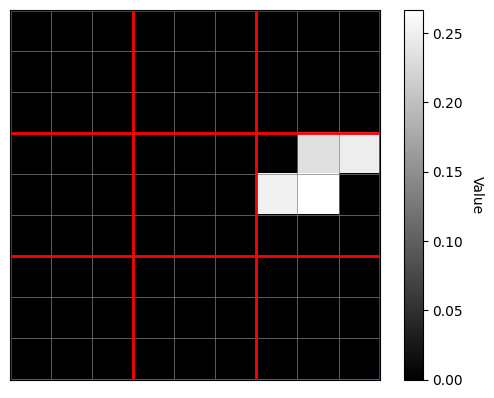

In [117]:
plot_decision(output)